In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cv2
import csv

In [2]:
# obstacles = {"O1": (13, 14), "O2": (15, 16), "O3": (21, 22), "O4": (23, 24)}
# ramps = {"R1": (19, 77), "R2": (76, 78)}
# starts = {"S1": 25, "S2": 26}
# blocks = {
#     "B1": 1, "B2": 2, "B3": 3, "B4": 4,
#     "B5": 5, "B6": 6, "B7": 7, "B8": 8,
#     "B9": 9, "B10": 10, "B11": 11, "B12": 12
# }
# deposits = {
#     "D1": (68, 69),  # Multiple points for D1
#     "D2": (66, 67),  # Multiple points for D2
#     "D3": (74,),     # Single point as tuple
#     "D4": (72,),     # Single point as tuple
#     "D5": (73,),      # Single point as tuple
#     "D6": (70, 71)
# }

In [3]:
obstacles = {"O1": (15, 16), "O2": (17, 18), "O3": (19, 20), "O4": (21, 22)}
ramps = {"R1": (23, 24), "R2": (25, 26)}
starts = {"S1": 13, "S2": 14}
blocks = {
    "B1": 1, "B2": 2, "B3": 3, "B4": 4,
    "B5": 5, "B6": 6, "B7": 7, "B8": 8,
    "B9": 9, "B10": 10, "B11": 11, "B12": 12
}
deposits = {
    "D1": (32, 33),  # Multiple points for D1
    "D2": (34, 35),  # Multiple points for D2
    "D3": (36,),     # Single point as tuple
    "D4": (37,),     # Single point as tuple
    "D5": (38,),      # Single point as tuple
    "D6": (39, 40)
}

In [4]:
obstacle_weight = 2.2 
ramp_weight = 4 

In [5]:
def animate_path_on_arena(detailed_path, points, arena_img_path="arena_resized.png"):
    # Load arena image
    arena_img = cv2.imread(arena_img_path)
    arena_img_rgb = cv2.cvtColor(arena_img, cv2.COLOR_BGR2RGB)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    def update(frame):
        ax.clear()
        
        # Show arena image
        ax.imshow(arena_img_rgb)
        
        # Only plot points that are part of the path up to current frame
        active_points = set(detailed_path[:frame + 1])
        for point_num in active_points:
            coords = points[point_num]
            ax.plot(coords[0], coords[1], 'ro', markersize=5)
        
        # Plot path up to current frame
        for i in range(min(frame + 1, len(detailed_path) - 1)):
            point1 = points[detailed_path[i]]
            point2 = points[detailed_path[i + 1]]
            ax.plot([point1[0], point2[0]], [point1[1], point2[1]], 
                   'g-', linewidth=2, alpha=0.7)
            
            # Highlight current edge
            if i == frame:
                ax.plot([point1[0], point2[0]], [point1[1], point2[1]], 
                       'y-', linewidth=3, alpha=1.0)
        
        ax.axis('off')
        plt.tight_layout()
    
    # Create animation
    anim = animation.FuncAnimation(
        fig, update, 
        frames=len(detailed_path) - 1,
        interval=500,  # 500ms = 0.5 seconds
        repeat=False
    )
    
    # Save animation
    anim.save('path_animation.gif', writer='pillow', fps=2)
    
    plt.show()

# Convert points to format needed for plotting
point_coords = {}
with open('arena_points_finals.csv', 'r') as file:
    csv_reader = csv.DictReader(file)
    for row in csv_reader:
        point_coords[int(row['Point'])] = (int(row['X']), int(row['Y']))

# Animate the minimum weight path


In [6]:
def convert_to_named_path(path):
    # Create reverse mappings
    start_points = {v: k for k, v in starts.items()}
    block_points = {v: k for k, v in blocks.items()}
    
    # For deposits, need to check each tuple
    deposit_points = {}
    for k, v in deposits.items():
        for point in v:
            deposit_points[point] = k
            
    # Create list for new path
    named_path = path.copy()
    
    # Replace individual points
    for i, point in enumerate(named_path):
        if point in start_points:
            named_path[i] = start_points[point]
        elif point in block_points:
            named_path[i] = block_points[point]
        elif point in deposit_points:
            named_path[i] = deposit_points[point]
    
    # Replace obstacle pairs
    i = 0
    while i < len(named_path) - 1:
        for obs_name, (p1, p2) in obstacles.items():
            if (named_path[i] == p1 and named_path[i+1] == p2) or \
               (named_path[i] == p2 and named_path[i+1] == p1):
                named_path[i:i+2] = [obs_name]
                i -= 1
                break
        i += 1
    
    # Replace ramp pairs
    i = 0
    while i < len(named_path) - 1:
        for ramp_name, (p1, p2) in ramps.items():
            if (named_path[i] == p1 and named_path[i+1] == p2) or \
               (named_path[i] == p2 and named_path[i+1] == p1):
                named_path[i:i+2] = [ramp_name]
                i -= 1
                break
        i += 1
        
    named_path = [point for point in named_path if not isinstance(point, int)]

    
    return named_path

# Convert and print the path
# named_path = convert_to_named_path(detailed_path)
# print(" -> ".join(str(x) for x in named_path))

In [7]:
import networkx as nx
import cv2
from collections import defaultdict
import csv

# Load visualization edges
viz_edges = {}
with open('arena_edges_final.csv', 'r') as file:
    csv_reader = csv.DictReader(file)
    for row in csv_reader:
        p1, p2 = int(row['Point1']), int(row['Point2'])
        edge = tuple(sorted([p1, p2]))
        viz_edges[edge] = 1

# Load true weights
true_weights = {}
with open('arena_weights.csv', 'r') as file:
    csv_reader = csv.DictReader(file)
    for row in csv_reader:
        p1, p2 = int(row['Point1']), int(row['Point2'])
        edge = tuple(sorted([p1, p2]))
        true_weights[edge] = float(row['Time'])

def get_active_features():
    """Get user input for active obstacles and ramps"""
    print("\n=== Setup Active Features ===")
    
    # Get obstacles
    print("\nAvailable obstacles:", list(obstacles.keys()))
    obstacle_input = input("Enter active obstacles (space-separated, e.g., 'O1 O2') or press Enter for none: ")
    active_obstacles = obstacle_input.split() if obstacle_input else []
    
    # Get ramps
    print("\nAvailable ramps:", list(ramps.keys()))
    ramp_input = input("Enter active ramps (space-separated, e.g., 'R1 R2') or press Enter for none: ")
    active_ramps = ramp_input.split() if ramp_input else []

    blocks = int(input("How many blocks: "))
        
    return active_obstacles, active_ramps, blocks



In [8]:
import math

In [9]:
def calculate_dynamic_cost(path, active_obs, active_rmps, blocks):
    current_usage = defaultdict(int)
    total_cost = 0
    feature_usage = []
    OB = 0
    RB = 0
    TURN_90_TIME = 1.0  # 1 second for 90-degree turn

    def calculate_angle(point0, point1, point2):
        """Calculate angle between three points in degrees"""
        if point0 is None:  # First segment has no turning cost
            return 0
            
        x0, y0 = point_coords[point0]
        x1, y1 = point_coords[point1]
        x2, y2 = point_coords[point2]
        
        # Get vectors
        vector1 = (x1 - x0, y1 - y0)
        vector2 = (x2 - x1, y2 - y1)
        
        # Calculate angle using dot product
        dot_product = vector1[0]*vector2[0] + vector1[1]*vector2[1]
        v1_magnitude = (vector1[0]**2 + vector1[1]**2)**0.5
        v2_magnitude = (vector2[0]**2 + vector2[1]**2)**0.5
        
        # Prevent division by zero
        if v1_magnitude * v2_magnitude == 0:
            return 0
            
        cos_angle = dot_product / (v1_magnitude * v2_magnitude)
        # Handle floating point errors
        cos_angle = min(1, max(-1, cos_angle))
        angle_rad = math.acos(cos_angle)
        angle_deg = math.degrees(angle_rad)
        
        return angle_deg

    # for i in range(len(path) - 1):
    #     print(i)
    #     p1, p2 = path[i], path[i+1]
    #     edge = tuple(sorted([p1, p2]))
    #     base_cost = true_weights[edge]
        
    #     # Track if edge is a special feature
    #     is_special = False
        
    #     # Check active obstacles
    #     for obs_name in active_obs:
    #         if obs_name in obstacles:
    #             o1, o2 = obstacles[obs_name]
    #             if (p1 == o1 and p2 == o2) or (p1 == o2 and p2 == o1):
    #                 is_special = True
    #                 if current_usage[obs_name] < 2:
    #                     OB += 1
    #                     total_cost += obstacle_weight 
    #                     feature_usage.append(f"Used {obs_name} ({current_usage[obs_name]+1})")
    #                 else:
    #                     total_cost += base_cost
    #                 current_usage[obs_name] += 1
    #                 break
        
    #     # Only check ramps if not an obstacle
    #     if not is_special:
    #         for ramp_name in active_rmps:
    #             if ramp_name in ramps:
    #                 r1, r2 = ramps[ramp_name]
    #                 if (p1 == r1 and p2 == r2) or (p1 == r2 and p2 == r1):
    #                     is_special = True
    #                     if current_usage[ramp_name] < 2:
    #                         RB += 1
    #                         total_cost += ramp_weight 
    #                         feature_usage.append(f"Used {ramp_name} ({current_usage[ramp_name]+1})")
    #                     else:
    #                         total_cost += base_cost
    #                     current_usage[ramp_name] += 1
    #                     break
        
    #     # If edge is neither obstacle nor ramp
    #     if not is_special:
    #         total_cost += base_cost

    for i in range(len(path) - 1):
        p1, p2 = path[i], path[i+1]
        p0 = path[i-1] if i > 0 else None
        edge = tuple(sorted([p1, p2]))
        base_cost = true_weights[edge]
        
        # Add turning time based on angle
        angle = calculate_angle(p0, p1, p2)
        turning_time = (angle/90.0) * TURN_90_TIME
        turn_cost = turning_time
        
        # print(f"Segment {p1}->{p2}: Base={base_cost:.2f}, Turn={turn_cost:.2f} (angle={angle:.1f}°)")
        
        # Track if edge is a special feature
        is_special = False
        
        # Check active obstacles
        for obs_name in active_obs:
            if obs_name in obstacles:
                o1, o2 = obstacles[obs_name]
                if (p1 == o1 and p2 == o2) or (p1 == o2 and p2 == o1):
                    is_special = True
                    if current_usage[obs_name] < 2:
                        OB += 1
                        total_cost += obstacle_weight + turn_cost
                        feature_usage.append(f"Used {obs_name} ({current_usage[obs_name]+1})")
                    else:
                        total_cost += obstacle_weight + turn_cost
                    current_usage[obs_name] += 1
                    break
        
        # Only check ramps if not an obstacle
        if not is_special:
            for ramp_name in active_rmps:
                if ramp_name in ramps:
                    r1, r2 = ramps[ramp_name]
                    if (p1 == r1 and p2 == r2) or (p1 == r2 and p2 == r1):
                        is_special = True
                        if current_usage[ramp_name] < 2:
                            RB += 1
                            total_cost += ramp_weight + turn_cost
                            feature_usage.append(f"Used {ramp_name} ({current_usage[ramp_name]+1})")
                        else:
                            total_cost += ramp_weight + turn_cost
                        current_usage[ramp_name] += 1
                        break
        
        # If edge is neither obstacle nor ramp
        if not is_special:
            total_cost += base_cost + turn_cost


    T = total_cost
    CP = blocks
    CD = blocks
    BP = 0
    DP = 0
    GP = 0
    MI = 0
    PP = 0
    B = 1


    score = (600-T)+(200*CP)+(200*CD)+(25*OB)+(50*RB)+(200*B)-(50*BP+100*PP+100*GP+150*DP+200*MI)
    print("Time: ", T)
    print("Obstacle Bonus: ", OB)
    print(score)
    
    return total_cost, current_usage, feature_usage

In [10]:
def interactive_path_builder():
    # Get active features first
    active_obstacles, active_ramps, blocks = get_active_features()
    
    # Create graph for pathfinding
    G = nx.Graph()
    for (p1, p2), _ in viz_edges.items():
        G.add_edge(p1, p2, weight=1)
    
    # Load arena image
    arena_img = cv2.imread("arena_resized.png")
    points_list = []  # Keep track of clicked points
    window_closed = False  # Flag to track window state
    
    # Load point coordinates
    point_coords = {}
    with open('arena_points_finals.csv', 'r') as file:
        csv_reader = csv.DictReader(file)
        for row in csv_reader:
            point_coords[int(row['Point'])] = (int(row['X']), int(row['Y']))
    
    def find_nearest_point(click_x, click_y):
        """Find the nearest valid point to clicked coordinates"""
        min_dist = float('inf')
        nearest_point = None
        for point, (x, y) in point_coords.items():
            dist = ((x - click_x) ** 2 + (y - click_y) ** 2) ** 0.5
            if dist < min_dist:
                min_dist = dist
                nearest_point = point
        return nearest_point if min_dist < 20 else None  # Only if within 20 pixels
    
    def mouse_callback(event, x, y, flags, param):
        nonlocal window_closed
        if event == cv2.EVENT_LBUTTONDOWN:
            point = find_nearest_point(x, y)
            if point is not None:
                # Check if it's a valid next point
                if not points_list:  # First point must be S1 or S2
                    if point not in [starts['S1'], starts['S2']]:
                        print("First point must be S1 or S2!")
                        return
                    starting_point = point
                elif point in [starts['S1'], starts['S2']]:
                    # Allow returning to starting point or reaching opposite start
                    final_segment = nx.shortest_path(G, points_list[-1], point, weight='weight')
                    points_list.extend(final_segment[1:])
                    window_closed = True
                    cv2.destroyAllWindows()
                    return
                
                # Get intermediate points if not first point
                if points_list:
                    try:
                        segment = nx.shortest_path(G, points_list[-1], point, weight='weight')
                        points_list.extend(segment[1:])  # Add all but first point to avoid duplicates
                    except nx.NetworkXNoPath:
                        print("No path found!")
                        return
                else:
                    points_list.append(point)
                
                # Draw updated path
                img = arena_img.copy()
                
                # Draw all points
                for p, (px, py) in point_coords.items():
                    cv2.circle(img, (px, py), 3, (0, 0, 255), -1)  # Red dots
                
                # Draw complete path
                if len(points_list) >= 2:
                    for i in range(len(points_list) - 1):
                        p1, p2 = points_list[i], points_list[i+1]
                        pt1 = point_coords[p1]
                        pt2 = point_coords[p2]
                        cv2.line(img, pt1, pt2, (0, 255, 0), 2)  # Green line
                
                # Highlight all points in path
                for p in points_list:
                    px, py = point_coords[p]
                    cv2.circle(img, (px, py), 5, (255, 255, 0), -1)  # Yellow dots
                
                cv2.imshow('Arena Path Builder', img)
                # print(f"Current path: {' -> '.join(map(str, points_list))}")


    # Initial display
    img = arena_img.copy()
    for p, (px, py) in point_coords.items():
        cv2.circle(img, (px, py), 3, (0, 0, 255), -1)
    cv2.imshow('Arena Path Builder', img)
    cv2.setMouseCallback('Arena Path Builder', mouse_callback)
    
    print("\nClick points to build path. Press 'q' to finish.")
    print("First point must be S1 (25) or S2 (26)")
    while not window_closed:
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            if len(points_list) >= 2:  # Only quit if we have a valid path
                window_closed = True
                cv2.destroyAllWindows()
                break
        
        # Check if window was closed by user
        try:
            if cv2.getWindowProperty('Arena Path Builder', cv2.WND_PROP_VISIBLE) < 1:
                window_closed = True
                break
        except:
            window_closed = True
            break
    
    if len(points_list) < 2:
        print("Need at least 2 points to make a path!")
        return None, None
    
    # # Calculate true cost using the same function as before
    # detailed_path = []
    # for i in range(len(points_list)-1):
    #     segment = nx.shortest_path(G, points_list[i], points_list[i+1], weight='weight')
    #     if i == 0:
    #         detailed_path.extend(segment)
    #     else:
    #         detailed_path.extend(segment[1:])
    print("DONE")
    true_cost, usage, features = calculate_dynamic_cost(
        points_list, active_obstacles, active_ramps, blocks)
    
    print("\n=== Path Summary ===")
    print(f"Complete path: {' -> '.join(map(str, points_list))}")
    print(f"True path cost: {true_cost:.2f}")
    print("\nFeature usage sequence:")
    for feature in features:
        print(f"- {feature}")
    
    return points_list, true_cost


In [11]:
# Run the interactive path builder
path, cost = interactive_path_builder()


=== Setup Active Features ===

Available obstacles: ['O1', 'O2', 'O3', 'O4']

Available ramps: ['R1', 'R2']

Click points to build path. Press 'q' to finish.
First point must be S1 (25) or S2 (26)
DONE
Time:  174.8585931334611
Obstacle Bonus:  7
2500.141406866539

=== Path Summary ===
Complete path: 13 -> 27 -> 15 -> 16 -> 56 -> 31 -> 3 -> 41 -> 29 -> 17 -> 18 -> 48 -> 47 -> 45 -> 37 -> 45 -> 47 -> 48 -> 4 -> 24 -> 23 -> 33 -> 23 -> 58 -> 44 -> 19 -> 20 -> 19 -> 20 -> 45 -> 47 -> 48 -> 10 -> 49 -> 50 -> 51 -> 52 -> 26 -> 25 -> 55 -> 29 -> 41 -> 34 -> 41 -> 29 -> 55 -> 9 -> 55 -> 29 -> 17 -> 18 -> 48 -> 49 -> 40 -> 49 -> 57 -> 22 -> 21 -> 22 -> 21 -> 46 -> 53 -> 54 -> 14
True path cost: 174.86

Feature usage sequence:
- Used O1 (1)
- Used O2 (1)
- Used R1 (1)
- Used O3 (1)
- Used O3 (2)
- Used R2 (1)
- Used O2 (2)
- Used O4 (1)
- Used O4 (2)


In [12]:
print(cost)

174.8585931334611


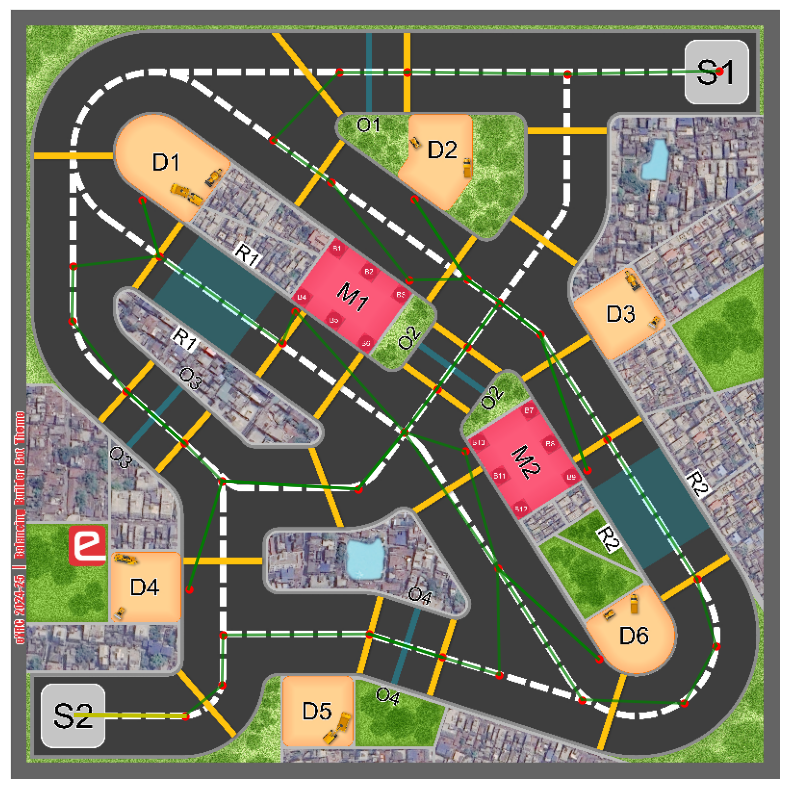

In [13]:
if path:
    # Visualize the path
    animate_path_on_arena(path, point_coords)

In [14]:
convert_to_named_path(path)

['S1',
 'O1',
 'B3',
 'O2',
 'D4',
 'B4',
 'R1',
 'D1',
 'O3',
 'O3',
 'B10',
 'R2',
 'D2',
 'B9',
 'O2',
 'D6',
 'O4',
 'O4',
 'S2']